This lab on PCS and PLS in R comes from p. 256-259 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. It was re-implemented in Fall 2016 in `tidyverse` format by Amelia McNamara and R. Jordan Crouser at Smith College.

# 6.7.1 Principal Components Regression

Principal components regression (PCR) can be performed using the `pcr()`
function, which is part of the `pls` library. In this lab, we'll apply PCR to the `Hitters`
data, in order to predict `Salary`. As in previous labs, we'll start by ensuring that the missing values have
been removed from the data:

In [1]:
list.of.packages <- c("dplyr","ISLR","pls","tidyr")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)

Installing package into ‘/home/iserina/R/x86_64-pc-linux-gnu-library/3.5’
(as ‘lib’ is unspecified)


In [2]:
library(ISLR)
library(dplyr)
library(tidyr)
library(pls)
Hitters = na.omit(Hitters) # Omit empty rows


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘pls’

The following object is masked from ‘package:stats’:

    loadings



The syntax for the `pcr()` function is similar to that for `lm()`, with a few
additional options. Setting `scale=TRUE` has the effect of standardizing each
predictor prior to generating the principal components, so that
the scale on which each variable is measured will not have an effect. Setting
`validation="CV"` causes `pcr()` to compute the ten-fold cross-validation error
for each possible value of $M$, the number of principal components used.  As usual, we'll set a random seed for consistency:

In [3]:
set.seed(2)
pcr_fit = pcr(Salary~., data = Hitters, scale = TRUE, validation = "CV")

The resulting fit can be examined using the `summary()` function:

In [4]:
summary(pcr_fit)

Data: 	X dimension: 263 19 
	Y dimension: 263 1
Fit method: svdpc
Number of components considered: 19

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV             452    348.9    352.2    353.5    352.8    350.1    349.1
adjCV          452    348.7    351.8    352.9    352.1    349.3    348.0
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV       349.6    350.9    352.9     353.8     355.0     356.2     363.5
adjCV    348.5    349.8    351.6     352.3     353.4     354.5     361.6
       14 comps  15 comps  16 comps  17 comps  18 comps  19 comps
CV        355.2     357.4     347.6     350.1     349.2     352.6
adjCV     352.8     355.2     345.5     347.6     346.7     349.8

TRAINING: % variance explained
        1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X         38.31    60.16    70.84    79.03    84.29    88.63    92.26    94.96
Salary    4

The CV score is provided for each possible number of components, ranging
from $M = 0$ onwards. Note that `pcr()` reports the **root mean squared error**; in order to obtain
the usual MSE, we must square this quantity. For instance, a root mean
squared error of 352.8 corresponds to an MSE of 352.82 = 124,468.

One can also plot the cross-validation scores using the `validationplot()`
function. Using `val.type="MSEP"` will cause the cross-validation MSE to be
plotted:

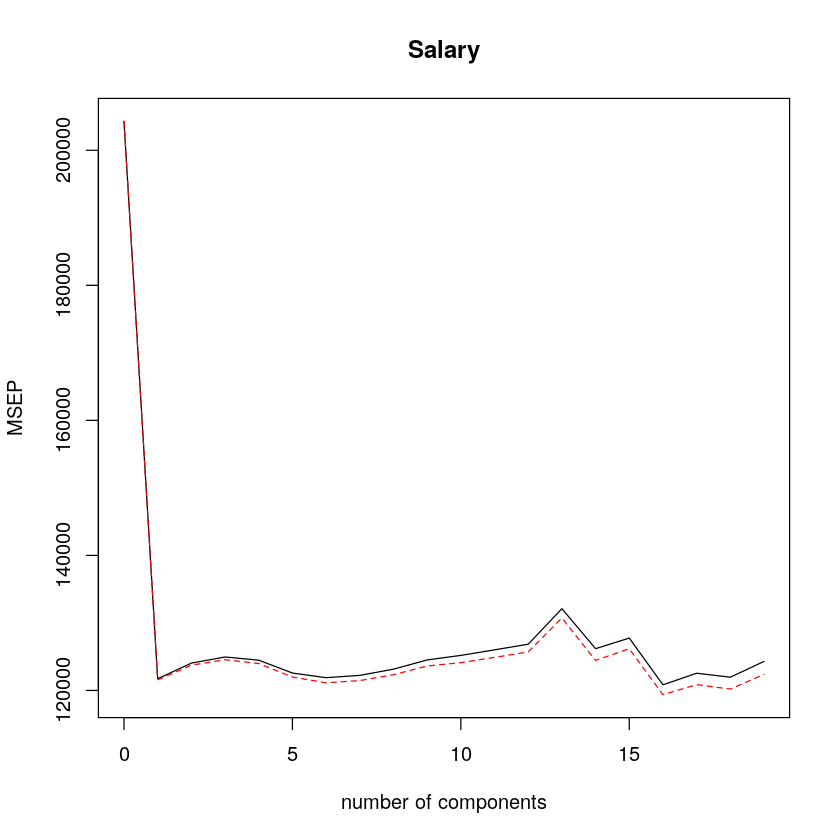

In [5]:
validationplot(pcr_fit, val.type = "MSEP")

We see that the smallest cross-validation error occurs when $M = 16$ components
are used. This is barely fewer than $M = 19$, which amounts to
simply performing least squares, because when all of the components are
used in PCR no dimension reduction occurs. However, from the plot we
also see that the cross-validation error is roughly the same when only one
component is included in the model. This suggests that a model that uses
just a small number of components might suffice.

You might have noticed that the `summary()` function also provides the percentage of variance explained
in the predictors and in the response using different numbers of components.
We'll dig deeper into this concept in Chapter 10, but for now we can think of this as the amount of information about the predictors or the response that is captured using $M$ principal components. For example,
setting $M = 1$ only captures 38.31% of all the variance, or information, in
the predictors. In contrast, using $M = 6$ increases the value to 88.63%. If
we were to use all $M = p = 19$ components, this would increase to 100%.

Now let's perform PCR on the training data and evaluate its test set
performance:

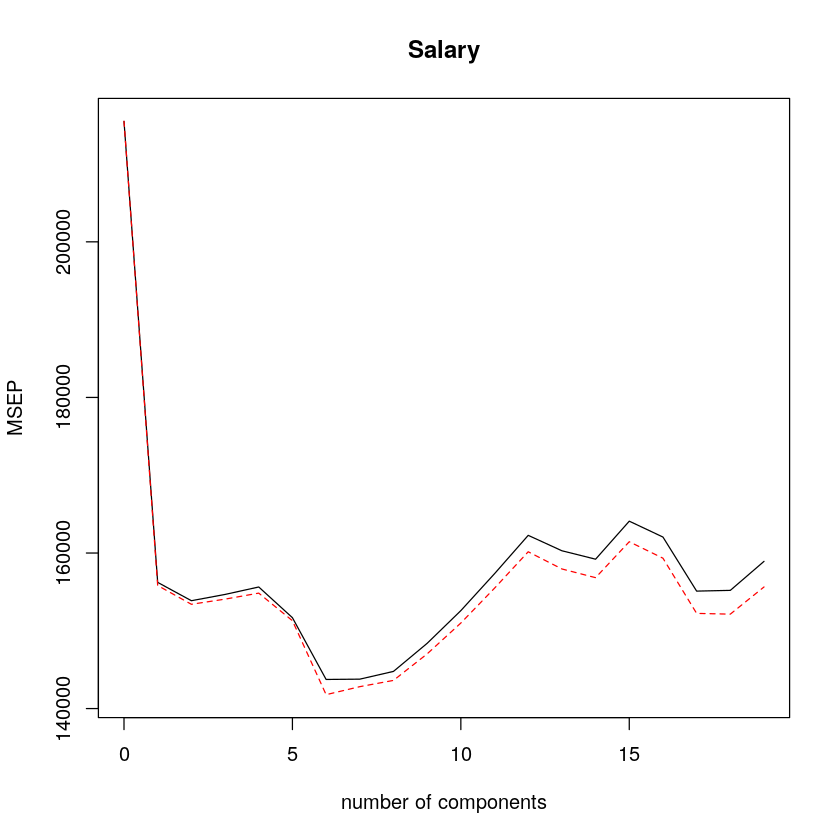

In [6]:
set.seed(1)

train = Hitters %>%
  sample_frac(0.5)

test = Hitters %>%
  setdiff(train)

pcr_fit2 = pcr(Salary~., data = train, scale = TRUE, validation = "CV")
validationplot(pcr_fit2, val.type = "MSEP")

We find that the lowest cross-validation error occurs when $M = 7$
components are used. We compute the test MSE as follows:

In [7]:
x_train = model.matrix(Salary~., train)[,-1]
x_test = model.matrix(Salary~., test)[,-1]

y_train = train %>%
  select(Salary) %>%
  unlist() %>%
  as.numeric()

y_test = test %>%
  select(Salary) %>%
  unlist() %>%
  as.numeric()

pcr_pred = predict(pcr_fit2, x_test, ncomp=7)
mean((pcr_pred-y_test)^2)

[1] 97208.93

This test set MSE is competitive with the results obtained using ridge regression
and the lasso. However, as a result of the way PCR is implemented,
the final model is more difficult to interpret because it does not perform
any kind of variable selection or even directly produce coefficient estimates.

Finally, we fit PCR on the full data set using $M = 7$, the number of
components identified by cross-validation:

In [8]:
x = model.matrix(Salary~., Hitters)[,-1]

y = Hitters %>%
  select(Salary) %>%
  unlist() %>%
  as.numeric()

pcr_fit2 = pcr(y~x, scale = TRUE, ncomp = 7)
summary(pcr_fit2)

Data: 	X dimension: 263 19 
	Y dimension: 263 1
Fit method: svdpc
Number of components considered: 7
TRAINING: % variance explained
   1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps
X    38.31    60.16    70.84    79.03    84.29    88.63    92.26
y    40.63    41.58    42.17    43.22    44.90    46.48    46.69


# 6.7.2 Partial Least Squares

Next we'll implement partial least squares (PLS) using the `plsr()` function, also
in the `pls` library. The syntax is just like that of the `pcr()` function:

Data: 	X dimension: 132 19 
	Y dimension: 132 1
Fit method: kernelpls
Number of components considered: 19

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           464.2    393.7    390.7    394.8    397.9    415.3    425.6
adjCV        464.2    392.9    389.3    392.6    395.6    411.3    420.0
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV       421.8    416.4    406.1     401.1     403.4     407.5     402.5
adjCV    416.3    411.6    402.0     396.5     398.9     402.7     398.1
       14 comps  15 comps  16 comps  17 comps  18 comps  19 comps
CV        397.8     401.2     403.0     401.0     399.8     401.8
adjCV     393.8     396.8     398.5     396.6     395.6     397.4

TRAINING: % variance explained
        1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X         38.26    53.56    66.06    74.49    79.40    84.57    87.07    90.76
Salary 

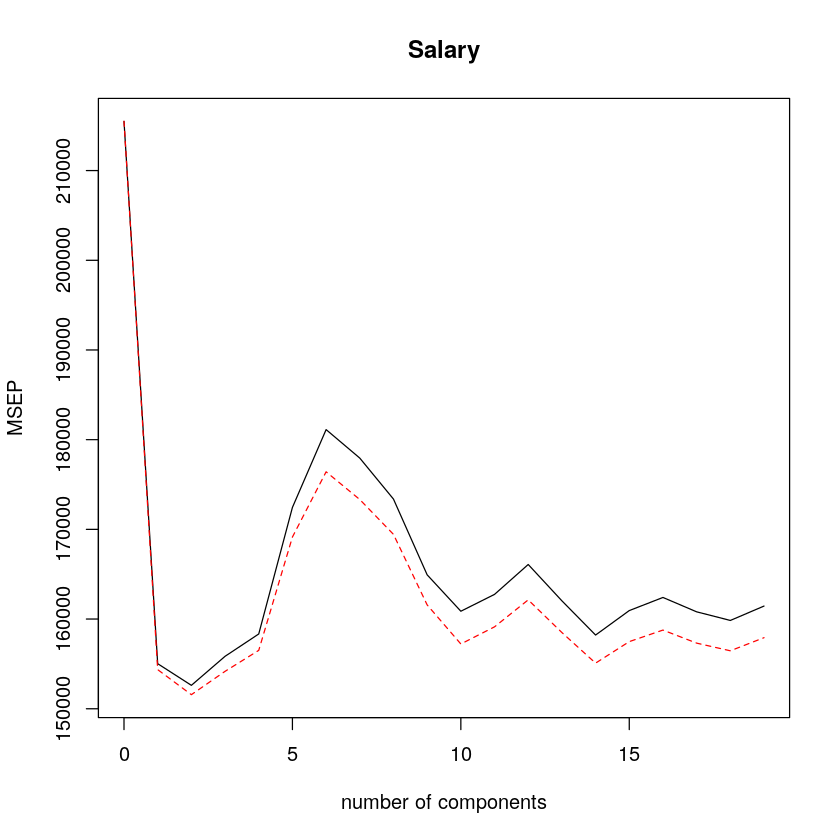

In [9]:
set.seed(1)
pls_fit = plsr(Salary~., data = train, scale = TRUE, validation = "CV")
summary(pls_fit)
validationplot(pls_fit, val.type = "MSEP")

The lowest cross-validation error occurs when only $M = 2$ partial least
squares dimensions are used. We now evaluate the corresponding test set
MSE:

In [10]:
pls_pred = predict(pls_fit, x_test, ncomp = 2)
mean((pls_pred - y_test)^2)

[1] 102089.7

The test MSE is comparable to, but slightly higher than, the test MSE
obtained using ridge regression, the lasso, and PCR.

Finally, we perform PLS using the full data set using $M = 2$, the number
of components identified by cross-validation:

In [11]:
pls_fit2 = plsr(Salary~., data = Hitters, scale = TRUE, ncomp = 2)
summary(pls_fit2)

Data: 	X dimension: 263 19 
	Y dimension: 263 1
Fit method: kernelpls
Number of components considered: 2
TRAINING: % variance explained
        1 comps  2 comps
X         38.08    51.03
Salary    43.05    46.40


The test MSE is again comparable to the test MSE
obtained using ridge regression, the lasso, and PCR.

# Your turn!
Now it's time to test out these approaches (PCR and PLS) and evaluation methods (validation set, cross validation) on other datasets. You may want to work with a team on this portion of the lab.
You may use any of the datasets included in ISLR, or choose one from the UCI machine learning repository (http://archive.ics.uci.edu/ml/datasets.html). Download a dataset, and try to determine the optimal set of parameters to use to model it! You are free to use the same dataset you used in Labs 9 and 10, or you can choose a new one.

In [12]:
# Your code here

To get credit for this lab, post your responses to the following questions:
 - Which dataset did you choose?
 - What was your response variable (i.e. what were you trying to model)?
 - Which method performed better?
 - Which method do you think tends to have lower bias?
 - Which method do you think tends to have lower variance?
 
to Moodle: https://moodle.smith.edu/mod/quiz/view.php?id=260068